In [1]:
from torch_geometric.explain import Explainer, AttentionExplainer, GNNExplainer, unfaithfulness
from cell_dataset import loadDataset

from genericpath import exists

from cell_model import Gatv2Predictor

import torch

import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

extension = "_open_ht_lv"
number_of_messages = 4
size_of_messages = 64
absolute = 0
distrib = "laplace"
aggr = "mean"
out = 8

name_complete = extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + distrib + "_" + str(out)

print(name_complete)

model_path = "models/new_model/out_" + str(out) + "_eps_-4/" + distrib + "/" + extension[6:] + "/model" + name_complete

data_train, data_test, data_val = loadDataset(load_all, extension, pre_separated, override)

_open_ht_lv_4_64_laplace_8
Validation data not found


In [3]:
epoch_to_load = 100

model = Gatv2Predictor(in_channels=12, out_channels=out, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, absolute=absolute)

print(model_path)

if exists(model_path + str(epoch_to_load) + ".pt") :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")

models/new_model/out_8_eps_-4/laplace/ht_lv/model_open_ht_lv_4_64_laplace_8
Loaded model


In [6]:
def explainer_explain(title, explainer, model) :
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    explainer.algorithm = explainer.algorithm.to(device)

    duration, x, _, _, border, params = data_test.get(0, duration=-1)

    params = params.to(device)
    x = x.to(device)

    figure = plt.figure(figsize=(10, 10))

    def animationFunction(i):
        #clear the figure
        plt.clf()
        
        print("Frame " + str(i) + "/" + str(duration) + " (" + str(i/duration*100) + "%)")
        
        end = i + 2
        start = end - 1

        _, edge_index, edge_attr = data_test.get_edges(x[start:end,:,:2].cpu(), data_test.max_degree, wrap=data_test.wrap, T=1, N=x.shape[1], masks=None)
        
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)

        # Generate the explanation for a particular graph:
        explanation = explainer(x=x[start:end][0], edge_index=edge_index, edge_attr=edge_attr, params=params)
        
        assert(explanation.validate() == True)

        exp = explanation.get_explanation_subgraph()
        
        g = torch_geometric.utils.to_networkx(exp, to_undirected=False, remove_self_loops=True)

        #draw the edges with the edge mask as the width
        widths = explanation.edge_mask.cpu().numpy()
        pos = exp.x[:,:2].cpu().numpy()
        
        nx.draw(g, pos=pos, with_labels=True, width=widths)
        
        return figure,

    anim = FuncAnimation(figure, animationFunction, frames=duration-1, interval=100, blit=True)

    anim.save(title + "_animation" + name_complete + ".gif", writer="ffmpeg")

Frame 0/99 (0.0%)
Frame 0/99 (0.0%)
Frame 0/99 (0.0%)
Frame 0/99 (0.0%)
Frame 1/99 (1.0101010101010102%)
Frame 2/99 (2.0202020202020203%)
Frame 3/99 (3.0303030303030303%)
Frame 4/99 (4.040404040404041%)
Frame 5/99 (5.05050505050505%)
Frame 6/99 (6.0606060606060606%)
Frame 7/99 (7.07070707070707%)
Frame 8/99 (8.080808080808081%)
Frame 9/99 (9.090909090909092%)
Frame 10/99 (10.1010101010101%)
Frame 11/99 (11.11111111111111%)
Frame 12/99 (12.121212121212121%)
Frame 13/99 (13.131313131313133%)
Frame 14/99 (14.14141414141414%)
Frame 15/99 (15.151515151515152%)
Frame 16/99 (16.161616161616163%)
Frame 17/99 (17.17171717171717%)
Frame 18/99 (18.181818181818183%)
Frame 19/99 (19.19191919191919%)
Frame 20/99 (20.2020202020202%)
Frame 21/99 (21.21212121212121%)
Frame 22/99 (22.22222222222222%)
Frame 23/99 (23.232323232323232%)
Frame 24/99 (24.242424242424242%)
Frame 25/99 (25.252525252525253%)
Frame 26/99 (26.262626262626267%)
Frame 27/99 (27.27272727272727%)
Frame 28/99 (28.28282828282828%)
Fram

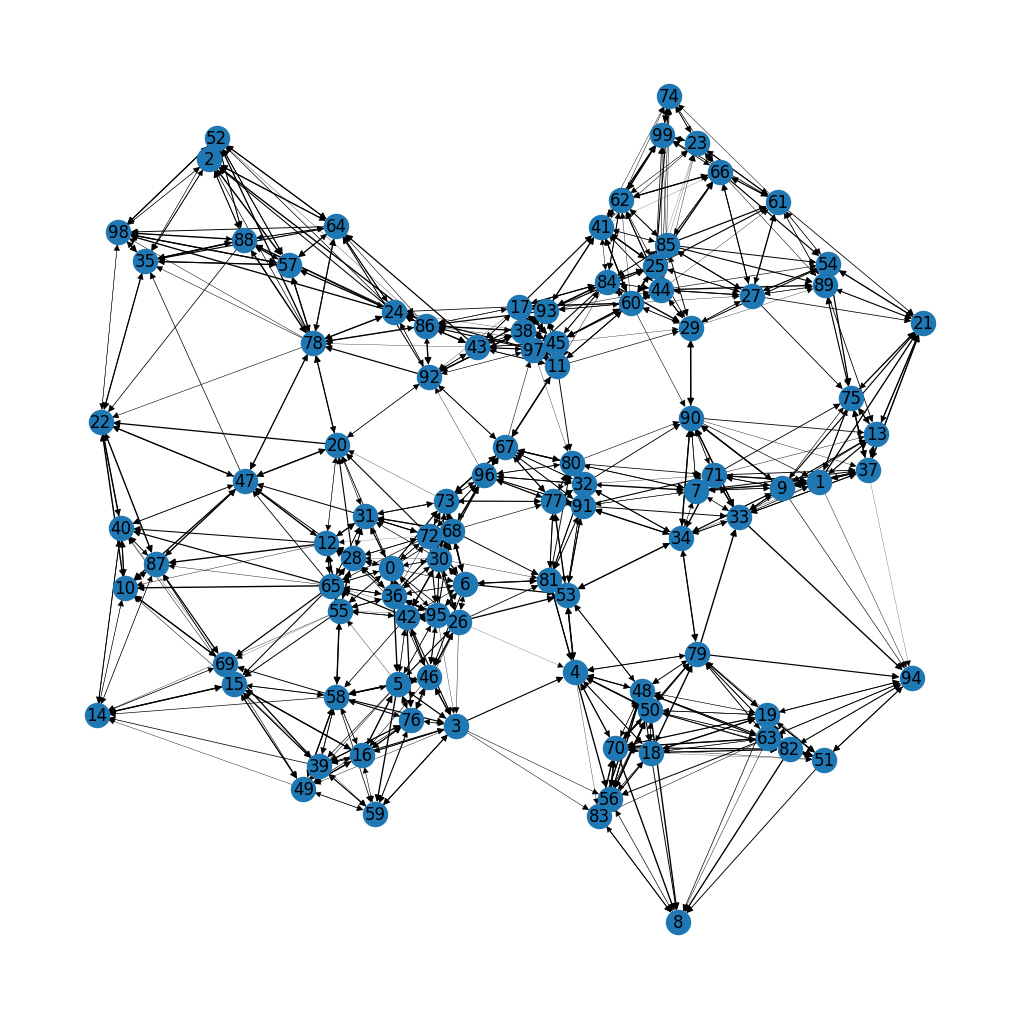

In [7]:
explainer = Explainer(
    model=model,
    algorithm=AttentionExplainer(),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

explainer_explain("Attention", explainer, model)

Frame 0/99 (0.0%)
Frame 0/99 (0.0%)
Frame 0/99 (0.0%)
Frame 0/99 (0.0%)
Frame 1/99 (1.0101010101010102%)
Frame 2/99 (2.0202020202020203%)
Frame 3/99 (3.0303030303030303%)
Frame 4/99 (4.040404040404041%)
Frame 5/99 (5.05050505050505%)
Frame 6/99 (6.0606060606060606%)
Frame 7/99 (7.07070707070707%)
Frame 8/99 (8.080808080808081%)
Frame 9/99 (9.090909090909092%)
Frame 10/99 (10.1010101010101%)
Frame 11/99 (11.11111111111111%)
Frame 12/99 (12.121212121212121%)
Frame 13/99 (13.131313131313133%)
Frame 14/99 (14.14141414141414%)
Frame 15/99 (15.151515151515152%)
Frame 16/99 (16.161616161616163%)
Frame 17/99 (17.17171717171717%)
Frame 18/99 (18.181818181818183%)
Frame 19/99 (19.19191919191919%)
Frame 20/99 (20.2020202020202%)
Frame 21/99 (21.21212121212121%)
Frame 22/99 (22.22222222222222%)
Frame 23/99 (23.232323232323232%)
Frame 24/99 (24.242424242424242%)
Frame 25/99 (25.252525252525253%)
Frame 26/99 (26.262626262626267%)
Frame 27/99 (27.27272727272727%)
Frame 28/99 (28.28282828282828%)
Fram

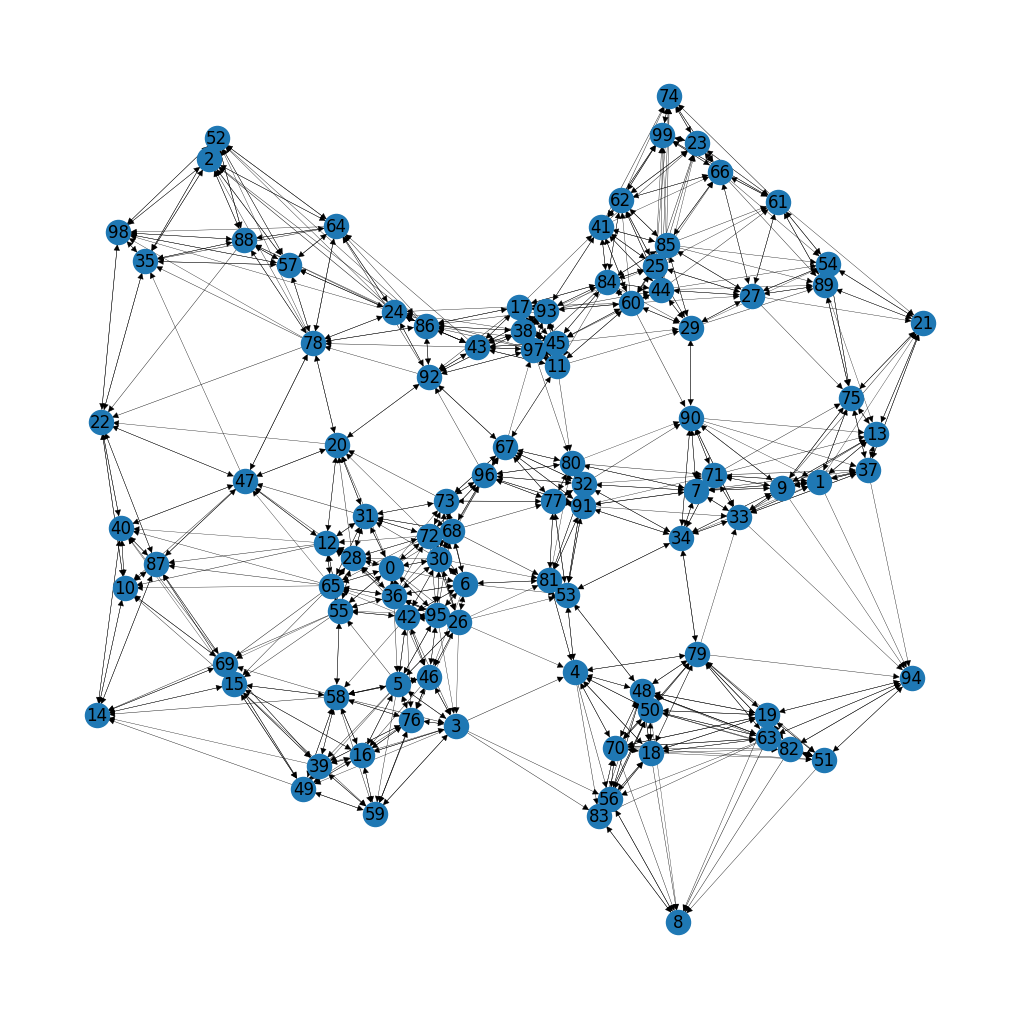

In [8]:
"""
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

explainer_explain("GNN", explainer, model)
"""

In [7]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
explainer.algorithm = explainer.algorithm.to(device)

duration, x, _, _, border, params = data_test.get(0, duration=-1)

xshape = x.shape

params = params.to(device)
x = x.to(device)

i = 50
    
end = i + 2
start = end - 1

_, edge_index, edge_attr = data_test.get_edges(x[start:end,:,:2].cpu(), data_test.max_degree, wrap=data_test.wrap, T=1, N=x.shape[1], masks=None)

edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

# Generate the explanation for a particular graph:
explanation = explainer(x=x[start:end][0], edge_index=edge_index, edge_attr=edge_attr, params=params)
      
assert(explanation.validate() == True)

explanation.visualize_feature_importance(path="node_explanation_" + str(start) + name_complete + ".png", feat_labels=["x", "y", "dx", "dy", "degree"])
